##### I - Libraries

In [ ]:
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import AzureChatOpenAI
import tempfile
import whisper
from pytubefix import YouTube
from pytubefix.cli import on_progress
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import AzureOpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_core.runnables import RunnablePassthrough
import os
load_dotenv()

##### II - First chain

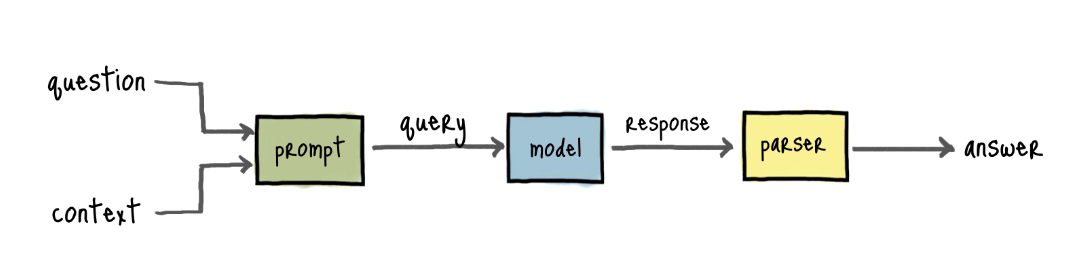

In [ ]:
model = AzureChatOpenAI(
    azure_deployment="gpt-4",  
    api_version="2024-08-01-preview" 
)

In [ ]:
parser = StrOutputParser()

In [ ]:
template = """
Answer the question based on the context below. If you can't 
answer the question, reply "I don't know".

Context: {context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = prompt | model | parser

##### III - Transcribing the YouTube Video

In [ ]:
YOUTUBE_VIDEO = "https://www.youtube.com/watch?v=cdiD-9MMpb0"

In [ ]:
if not os.path.exists("transcription.txt"):
    youtube = YouTube(YOUTUBE_VIDEO , on_progress_callback = on_progress)
    audio = youtube.streams.get_audio_only()
    
    if audio:
        whisper_model = whisper.load_model("base")
        with tempfile.TemporaryDirectory() as tmpdir:
            file = audio.download(output_path=tmpdir)
            transcription = whisper_model.transcribe(file, fp16=False)["text"].strip()
            
            with open("transcription.txt", "w") as file:
                file.write(transcription)  

##### VI - Splitting the transcription

In [ ]:
loader = TextLoader("transcription.txt")
text_documents = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=20)
documents = text_splitter.split_documents(text_documents)

In [ ]:
embeddings = AzureOpenAIEmbeddings(
    model="text-embedding-ada-002",
    chunk_size= 1
)

##### V - Setting up a Vector Store : Pinecone

In [ ]:
index_name = "youtube-rag-index"

pinecone = PineconeVectorStore.from_documents(
    documents, embeddings, index_name=index_name
)


##### IV - Combining chains

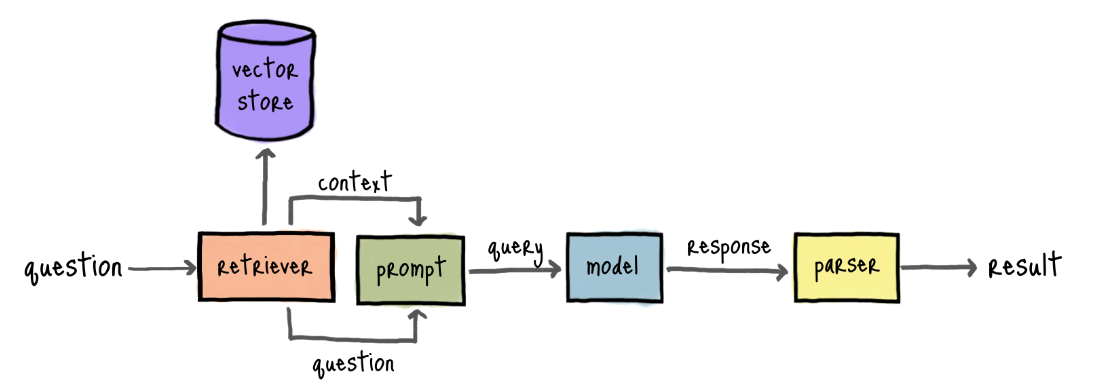

In [ ]:
chain = (
    {"context": pinecone.as_retriever(), "question": RunnablePassthrough()}
    | prompt
    | model
    | parser
)

chain.invoke("What is Hollywood going to start doing?")